## Reducción de la Dimensionalidad - PCA -
#### La maldición de la dimensionalidad
(covarianza → autovalores → autovectores → diagonalización → transformación)

Cómo usar esto como “guía real” (sin añadir teoría)

	•	Si tus variables tienen escalas distintas → usa StandardScaler antes de PCA.
	•	Si quieres reproducir el cálculo a mano → mira Paso 2–5 (Cx, eigh, PDP^T, T=XP).
	•	Si quieres hacerlo como en un proyecto → usa sklearn.PCA, pero entiende que:
		•	components_ son autovectores (en filas)
		•	explained_variance_ son autovalores (con la convención muestral interna de sklearn)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [2]:
""" Generación de un dataset “realista” (2D correlacionado)"""

# Semilla para reproducibilidad
rng = np.random.default_rng(42)

n = 250

# Generamos una nube de puntos 2D con fuerte correlación (forma elíptica)
x1 = rng.normal(loc=0.0, scale=3.0, size=n)
noise = rng.normal(loc=0.0, scale=0.8, size=n)
x2 = 0.8 * x1 + noise

X = np.column_stack([x1, x2])

print("Shape X:", X.shape)
print("Primeras 5 filas:\n", X[:5])

Shape X: (250, 2)
Primeras 5 filas:
 [[ 0.91415124  0.43672183]
 [-3.11995232 -2.22271741]
 [ 2.25135359  3.18404099]
 [ 2.82169415  1.46786966]
 [-5.85310557 -4.87870673]]


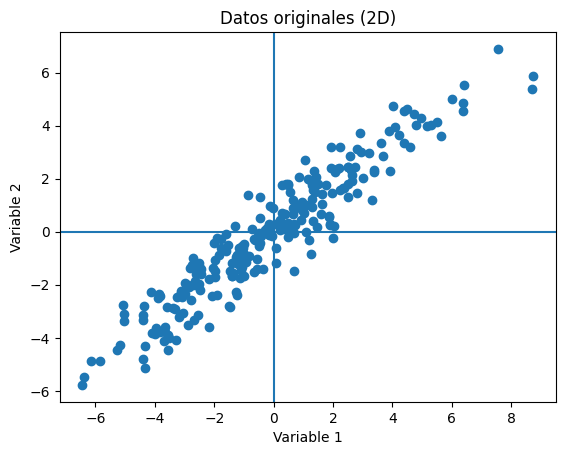

In [3]:
"""Visualización inicial (antes de preprocesar)"""

plt.figure()
plt.scatter(X[:, 0], X[:, 1])
plt.axhline(0)
plt.axvline(0)
plt.title("Datos originales (2D)")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.show()

In [4]:
"""Paso 0: diagnóstico rápido de escalas (media/varianza)"""

mu = X.mean(axis=0)
std = X.std(axis=0, ddof=0)

print("Media por columna:", mu)
print("Desv típica por columna (ddof=0):", std)

# Matriz de correlación (para ver dependencia lineal, opcional)
corr = np.corrcoef(X.T)
print("\nMatriz de correlación:\n", corr)

Media por columna: [-0.14595111 -0.09884243]
Desv típica por columna (ddof=0): [2.81686927 2.41590269]

Matriz de correlación:
 [[1.         0.94628376]
 [0.94628376 1.        ]]


In [5]:
"""Paso 1: centrado de datos (como en teoría)"""

# Paso 1 (a mano): centrado
Xc = X - X.mean(axis=0)

print("Media tras centrar (debería ~0):", Xc.mean(axis=0))

Media tras centrar (debería ~0): [6.21724894e-17 0.00000000e+00]


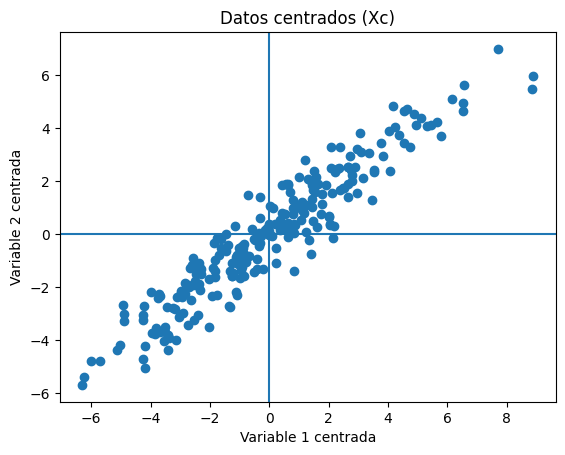

In [6]:
"""Visualización del centrado"""

plt.figure()
plt.scatter(Xc[:, 0], Xc[:, 1])
plt.axhline(0)
plt.axvline(0)
plt.title("Datos centrados (Xc)")
plt.xlabel("Variable 1 centrada")
plt.ylabel("Variable 2 centrada")
plt.show()

In [7]:
"""Paso 1b (proyecto real): estandarización (normalizar por desviación típica)"""

# En un caso real, normalmente estandarizamos antes de PCA si las variables tienen escalas distintas
scaler = StandardScaler(with_mean=True, with_std=True)
Xs = scaler.fit_transform(X)

print("Media Xs:", Xs.mean(axis=0))
print("Std Xs:", Xs.std(axis=0, ddof=0))

Media Xs: [ 3.64153152e-17 -6.21724894e-18]
Std Xs: [1. 1.]


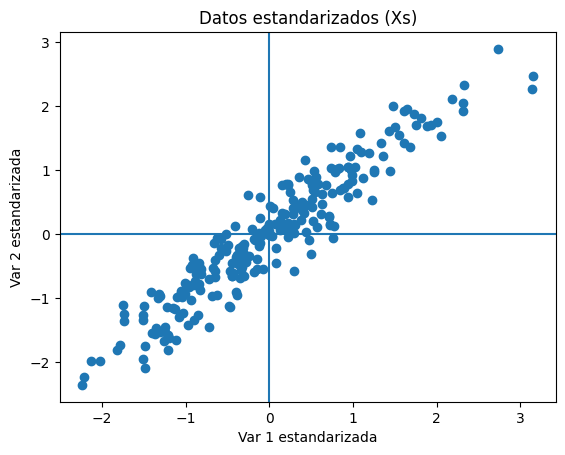

In [8]:
"""VVisualización tras estandarizar"""

plt.figure()
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.axhline(0)
plt.axvline(0)
plt.title("Datos estandarizados (Xs)")
plt.xlabel("Var 1 estandarizada")
plt.ylabel("Var 2 estandarizada")
plt.show()

In [9]:
"""A partir de aquí haremos PCA “a mano” con NumPy (igual que en papel) 
Paso 2: matriz de covarianzas C_X = (1/n) X^T X """

# Paso 2: Covarianza
n = Xs.shape[0]
Cx = (1/n) * (Xs.T @ Xs)

print("C_X:\n", Cx)
print("Simétrica:", np.allclose(Cx, Cx.T))

C_X:
 [[1.         0.94628376]
 [0.94628376 1.        ]]
Simétrica: True


In [10]:
"""Paso 3: autovalores y autovectores de C_X"""

# Paso 3: Autovalores y autovectores
# Para matrices simétricas es preferible eigh (más estable que eig)
eigvals, eigvecs = np.linalg.eigh(Cx)

# eigh devuelve autovalores ordenados ascendente; los reordenamos descendente
idx = np.argsort(eigvals)[::-1]
eigvals = eigvals[idx]
eigvecs = eigvecs[:, idx]

print("Autovalores (desc):", eigvals)
print("Autovectores (columnas):\n", eigvecs)

# Comprobación rápida: Cx v = lambda v
v0 = eigvecs[:, 0]
lhs = Cx @ v0
rhs = eigvals[0] * v0
print("\nCheck (norma lhs-rhs):", np.linalg.norm(lhs - rhs))

Autovalores (desc): [1.94628376 0.05371624]
Autovectores (columnas):
 [[-0.70710678  0.70710678]
 [-0.70710678 -0.70710678]]

Check (norma lhs-rhs): 2.220446049250313e-16


In [ ]:
"""Paso 4: diagonalización C_X = P D P^T"""

# Paso 4: Diagonalización
P = eigvecs
D = np.diag(eigvals)

Cx_recon = P @ D @ P.T

print("Reconstrucción Cx correcta:", np.allclose(Cx, Cx_recon))
print("P^T P = I:", np.allclose(P.T @ P, np.eye(P.shape[0])))

Reconstrucción Cx correcta: True
P^T P = I: True


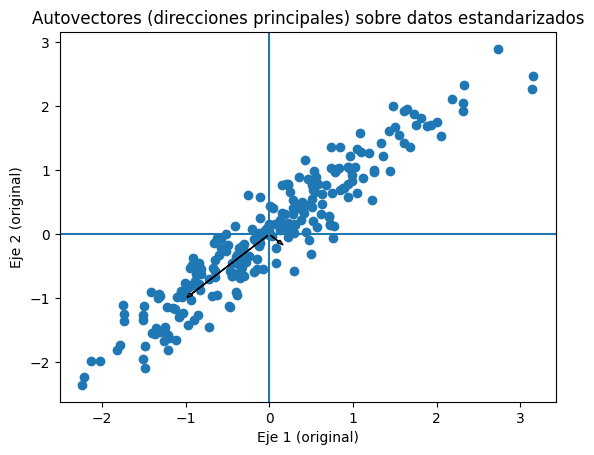

In [12]:
"""Visualización geométrica: autovectores sobre la nube (en Xs)"""

plt.figure()
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.axhline(0)
plt.axvline(0)

# Dibujamos autovectores (direcciones) como flechas desde el origen
# Escalamos la longitud por sqrt(autovalor) para que refleje "dispersión"
origin = np.array([0, 0])

for i in range(2):
    vec = P[:, i]
    length = np.sqrt(eigvals[i])
    plt.arrow(origin[0], origin[1], vec[0]*length, vec[1]*length, head_width=0.05, length_includes_head=True)

plt.title("Autovectores (direcciones principales) sobre datos estandarizados")
plt.xlabel("Eje 1 (original)")
plt.ylabel("Eje 2 (original)")
plt.show()

In [13]:
"""Paso 5: transformación de datos T = X P (componentes principales)"""

# Paso 5: Componentes principales (scores)
T = Xs @ P  # columnas de T = componentes principales

print("Shape T:", T.shape)
print("Cov(T) ~ D:", np.allclose((1/n) * (T.T @ T), D))
print("Cov(T):\n", (1/n) * (T.T @ T))
print("\nD:\n", D)

Shape T: (250, 2)
Cov(T) ~ D: True
Cov(T):
 [[ 1.94628376e+00 -1.06581410e-16]
 [-1.06581410e-16  5.37162356e-02]]

D:
 [[1.94628376 0.        ]
 [0.         0.05371624]]


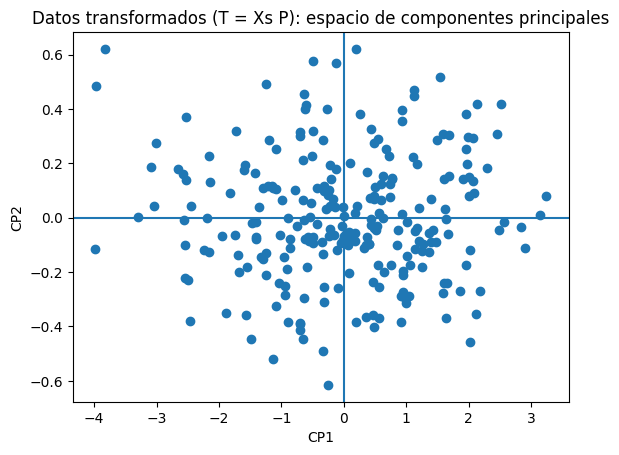

In [14]:
"""Visualización: datos en el espacio de componentes (T)"""

plt.figure()
plt.scatter(T[:, 0], T[:, 1])
plt.axhline(0)
plt.axvline(0)
plt.title("Datos transformados (T = Xs P): espacio de componentes principales")
plt.xlabel("CP1")
plt.ylabel("CP2")
plt.show()

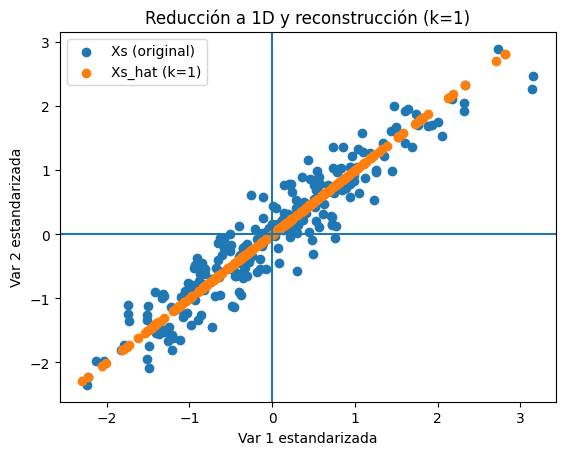

In [15]:
"""Visualización: proyección 1D (reducción a k=1) y comparación"""

# Reducción a k=1 (solo CP1)
k = 1
Tk = T[:, :k]         # scores en 1D
Pk = P[:, :k]         # primer autovector

# Reconstrucción aproximada en el espacio estandarizado:
# X_hat = Tk Pk^T
Xs_hat = Tk @ Pk.T

plt.figure()
plt.scatter(Xs[:, 0], Xs[:, 1], label="Xs (original)")
plt.scatter(Xs_hat[:, 0], Xs_hat[:, 1], label="Xs_hat (k=1)")
plt.axhline(0)
plt.axvline(0)
plt.title("Reducción a 1D y reconstrucción (k=1)")
plt.xlabel("Var 1 estandarizada")
plt.ylabel("Var 2 estandarizada")
plt.legend()
plt.show()

In [16]:
"""Varianza explicada y error residual (como en el PDF)"""

# Varianza total = suma de autovalores
total_var = eigvals.sum()

explained_ratio = eigvals / total_var
cum_explained = np.cumsum(explained_ratio)

print("Autovalores:", eigvals)
print("Proporción varianza explicada:", explained_ratio)
print("Acumulada:", cum_explained)

# Error residual para k componentes: suma de autovalores descartados
def residual_error(eigvals, k):
    return eigvals[k:].sum()

for k in [1, 2]:
    print(f"Error residual k={k}:", residual_error(eigvals, k))

Autovalores: [1.94628376 0.05371624]
Proporción varianza explicada: [0.97314188 0.02685812]
Acumulada: [0.97314188 1.        ]
Error residual k=1: 0.05371623558073718
Error residual k=2: 0.0


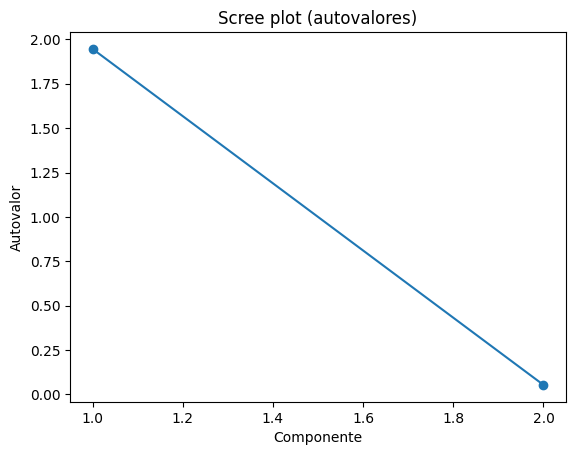

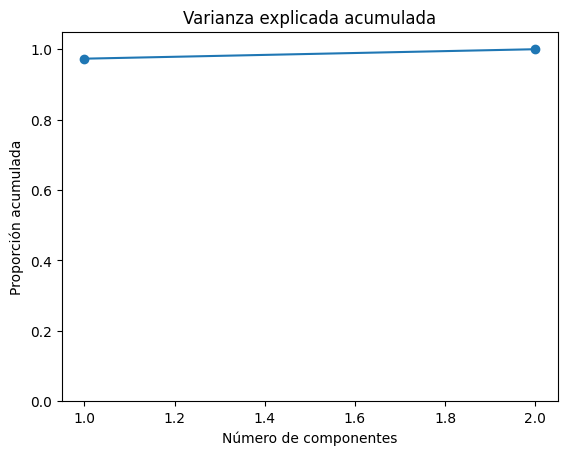

In [17]:
"""Gráfico tipo “scree” y varianza acumulada"""

plt.figure()
plt.plot(np.arange(1, len(eigvals)+1), eigvals, marker="o")
plt.title("Scree plot (autovalores)")
plt.xlabel("Componente")
plt.ylabel("Autovalor")
plt.show()

plt.figure()
plt.plot(np.arange(1, len(cum_explained)+1), cum_explained, marker="o")
plt.title("Varianza explicada acumulada")
plt.xlabel("Número de componentes")
plt.ylabel("Proporción acumulada")
plt.ylim(0, 1.05)
plt.show()

### Ahora hacemos lo mismo con scikit-learn (flujo típico profesional)

In [18]:
"""PCA con scikit-learn (comprobación vs “a mano”)"""

pca = PCA(n_components=2)
T_sklearn = pca.fit_transform(Xs)

print("Explained variance (sklearn):", pca.explained_variance_)
print("Explained variance ratio (sklearn):", pca.explained_variance_ratio_)
print("Components_ (sklearn):\n", pca.components_)  # Ojo: filas = componentes, equivalente a P^T

# Comparación básica:
# - sklearn components_ son vectores unitarios (autovectores) pero en filas.
# - Nuestros autovectores están en columnas de P.
P_sklearn = pca.components_.T
print("\nComparación |P| y |P_sklearn| (pueden diferir en signo):")
print(np.abs(P))
print(np.abs(P_sklearn))

Explained variance (sklearn): [1.95410017 0.05393196]
Explained variance ratio (sklearn): [0.97314188 0.02685812]
Components_ (sklearn):
 [[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]

Comparación |P| y |P_sklearn| (pueden diferir en signo):
[[0.70710678 0.70710678]
 [0.70710678 0.70710678]]
[[0.70710678 0.70710678]
 [0.70710678 0.70710678]]


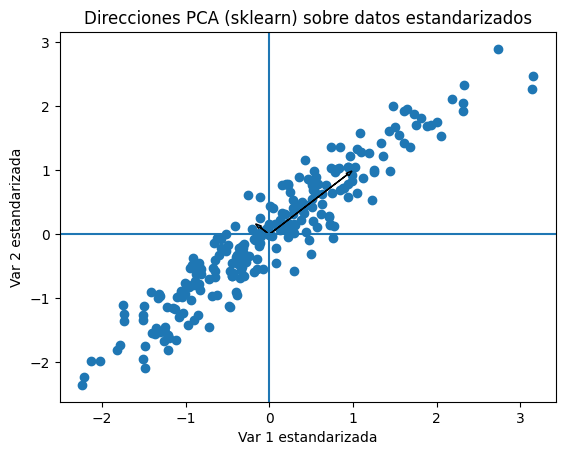

In [19]:
"""Visualización: equivalencia geométrica (sklearn)"""

plt.figure()
plt.scatter(Xs[:, 0], Xs[:, 1])
plt.axhline(0)
plt.axvline(0)

# Usamos P_sklearn para dibujar direcciones
for i in range(2):
    vec = P_sklearn[:, i]
    length = np.sqrt(pca.explained_variance_[i])  # varianza en CP
    plt.arrow(0, 0, vec[0]*length, vec[1]*length, head_width=0.05, length_includes_head=True)

plt.title("Direcciones PCA (sklearn) sobre datos estandarizados")
plt.xlabel("Var 1 estandarizada")
plt.ylabel("Var 2 estandarizada")
plt.show()

MSE reconstrucción (k=1) en escala original: 0.18493611300800206


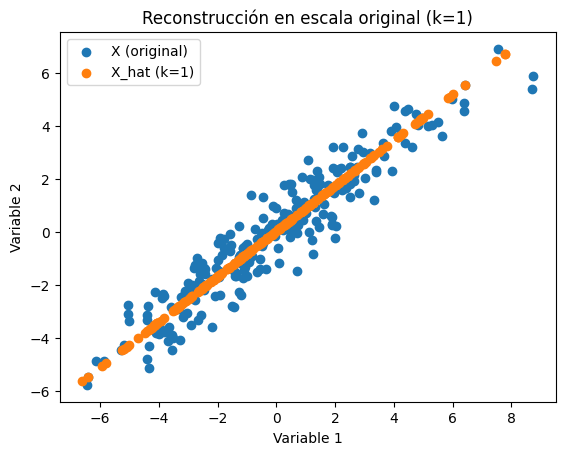

In [20]:
"""(Opcional) Volver a escala original: reconstrucción y error en unidades reales"""

# Reconstrucción desde k=1 con sklearn
pca1 = PCA(n_components=1)
T1 = pca1.fit_transform(Xs)
Xs_hat_1 = pca1.inverse_transform(T1)

# Pasamos de estandarizado a escala original:
X_hat_1 = scaler.inverse_transform(Xs_hat_1)

# Error medio cuadrático en escala original (solo como métrica orientativa)
mse = np.mean((X - X_hat_1)**2)
print("MSE reconstrucción (k=1) en escala original:", mse)

plt.figure()
plt.scatter(X[:, 0], X[:, 1], label="X (original)")
plt.scatter(X_hat_1[:, 0], X_hat_1[:, 1], label="X_hat (k=1)")
plt.title("Reconstrucción en escala original (k=1)")
plt.xlabel("Variable 1")
plt.ylabel("Variable 2")
plt.legend()
plt.show()